Medical Insurance Cost Prediction using Regression



Problem Statement:
    The medical insurance dataset encompasses various factors influencing medical expenses, such as age, sex, BMI, smoking status, number of children, and region. This dataset serves as a foundation for training machine learning models capable of forecasting medical expenses for new policyholders.

Its purpose is to shed light on the pivotal elements contributing to increased insurance costs, aiding the company in making more informed decisions concerning pricing and risk assessment.

    

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggel/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
medical_df = pd.read_csv('insurance.csv')

In [6]:
medical_df

age     sex   bmi  children smoker     region  expenses
0      19  female  27.9         0    yes  southwest  16884.92
1      18    male  33.8         1     no  southeast   1725.55
2      28    male  33.0         3     no  southeast   4449.46
3      33    male  22.7         0     no  northwest  21984.47
4      32    male  28.9         0     no  northwest   3866.86
...   ...     ...   ...       ...    ...        ...       ...
1333   50    male  31.0         3     no  northwest  10600.55
1334   18  female  31.9         0     no  northeast   2205.98
1335   18  female  36.9         0     no  southeast   1629.83
1336   21  female  25.8         0     no  southwest   2007.95
1337   61  female  29.1         0    yes  northwest  29141.36

[1338 rows x 7 columns]

The dataset contains 1338 rows and 7 columns. Each row of the dataset contains information about one customer.

Our objective is to find a way to estimate the value in the "charges" column using the values in the other columns. If we can do so for the historical data, then we should able to estimate charges for new customers too, simply by asking for information like their age, sex, BMI, no. of children, smoking habits and region.

In [7]:
#Exploring the data for higher level information
medical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Looks like "age", "children", "bmi" and "charges" are numbers, whereas "sex", "smoker" and "region" are strings (possibly categories). None of the columns contain any missing values, which saves us a fair bit of work!

Here are some statistics for the numerical columns:

In [8]:
medical_df.describe()

age          bmi     children      expenses
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.665471     1.094918  13270.422414
std      14.049960     6.098382     1.205493  12110.011240
min      18.000000    16.000000     0.000000   1121.870000
25%      27.000000    26.300000     0.000000   4740.287500
50%      39.000000    30.400000     1.000000   9382.030000
75%      51.000000    34.700000     2.000000  16639.915000
max      64.000000    53.100000     5.000000  63770.430000

The ranges of values in the numerical columns seem reasonable too, so we may not have to do much data cleaning or correction. The "charges" column seems to be significantly skewed however, as the median (50 percentile,it is also know as 2nd quartile) is much lower than the maximum value.

Exploratory Analysis and Visualization
Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "charges" and other columns.

We'll use libraries Matplotlib, Seaborn and Plotly for visualization.

In [9]:
!pip install plotly matplotlib seaborn --quiet

In [10]:
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


The following settings will improve the default style and font sizes for our charts.

In [12]:
sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'


Age

Age is a numeric column. The minimum age in the dataset is 18 and the maximum age is 64. Thus, we can visualize the distribution of age using a histogram with 47 bins (one for each year) and a box plot. We'll use plotly to make the chart interactive, but you can create similar charts using Seaborn.

In [13]:
medical_df.age.describe()

count    1338.000000
mean       39.207025
std        14.049960
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

In [14]:
fig = px.histogram(medical_df,
                  x = 'age',
                  marginal = 'box',
                  nbins = 47,
                  title = 'Distribution of Age')

fig.update_layout(bargap = 0.1)
fig.show()

The distribution of ages in the dataset is almost uniform, with 20-30 customers at every age, except for the ages 18 and 19, which seem to have over twice as many customers as other ages.

Insight: why there are over twice as many customers with ages 18 and 19, compared to other ages?

Insuarance agency charges more money for same premium as you get older and here is the same case.people who are younger are less prone to getting sick and thus company has to pay them less for their medical bills.otherwise every age group in US has eqvivalent population density.

Body Mass Index

Let's look at the distribution of BMI (Body Mass Index) of customers, using a histogram and box plot.

In [16]:
fig = px.histogram(medical_df,
                  x = 'bmi',
                  marginal = 'box',
                  color_discrete_sequence = ['red'],
                  title = 'Distribution of BMI (Body Mass Index)')
fig.update_layout(bargap = 0.1)
fig.show()

The measurements of body mass index seem to form a Gaussian distribution centered around the value 30, with a few outliers towards the right.

Insight:why the distribution of ages forms a uniform distribution while the distribution of BMIs forms a gaussian distribution?

As there are same number of people in age groups the distribution we get is uniform distribution.But, for BMIs distribution we get gaussian distribution as people who are between 20-3- are considered to be healthy relatively and less than or more than this range is considered to be health risk categories and these people are more prone to health issues and thus company will have to pay more medical bills of this kind of customers and thus they provide these type of people same health insuarance at higher prices and which in-turn attracts lesser people with out of healthy range BMI because they have to pay more.

Charges

Let's visualize the distribution of "charges" i.e. the annual medical charges for customers. This is the column we're trying to predict. Let's also use the categorical column "smoker" to distinguish the charges for smokers and non-smokers.

In [30]:
fig = px.histogram(medical_df,
                  x = 'expenses',
                  marginal = 'box',
                  color = 'smoker',
                  color_discrete_sequence = ['red', 'grey'],
                  title = 'Annual Medical Charges')
fig.update_layout(bargap = 0.1)
fig.show()

We can make the following observations from the above graph:

For most customers, the annual medical charges are under $10,000. Only a small fraction of customer have higher medical expenses, possibly due to accidents, major illnesses and genetic diseases. The distribution follows a "power law"
There is a significant difference in medical expenses between smokers and non-smokers. While the median for non-smokers is $7300, the median for smokers is close to \$35,000.

Visualization of the distribution of medical charges in connection with other factors like "sex" and "region".

In [37]:
fig = px.histogram(medical_df,
                   x = 'expenses',
                   color = 'sex',
                   color_discrete_sequence = ["blue","red"],
                   title = 'Different expenses over genders'
               
)
fig.update_layout(bargap=0.1)
fig.show()

In [33]:
fig = px.histogram(medical_df,
                  x = "expenses",
                  marginal = 'box', 
                   color="region",
                  title = "charges over different regions of U.S.A")
fig.update_layout(bargap=0.1)
fig.show()

Here in the distribution of charges over gender we see that males are substancially charged more because by subconsious behaviour males are exploratory and they are more likely to take risks and that keeps them in danger more than their counterpart.It is also evident that males of U.S are more inclined to get health insuarrance then female. And, in second distribution we see that southeaster part of U.S is leading in charges but majority of all customers from all parts of US are charged between 0-20k only.

Smoker:

Let's visualize the distribution of the "smoker" column (containing values "yes" and "no") using a histogram.

In [34]:
medical_df.smoker.value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [35]:
px.histogram(medical_df, x = 'smoker', color = 'sex', title = 'smoker')

It appears that 20% of customers have reported that they smoke.We can also see that smoking appears a more common habit among males. This is true for the given dataset only and so we should always verify if these results of analysis also matches the general population which we are going to use our model on otherwise the model will assume that in general population also 20 % people are smokers but in reality it was only 10 % so we would get incorrect predictions.So it is best to check if our primary data analysis matches the results of the general public.

Visualization of the distributions of the "sex", "region" and "children" columns

In [36]:
fig = px.histogram(medical_df,
                  x = 'expenses',
                   marginal ="box",
                  color = 'children',
                  title = 'Expenses incurred by children')
fig.update_layout(bargap=0.1)
fig.show()

It seems that majority of our customers have 0 or 1 child and median charges vary between 8.5k to 11k dollars

We can also conclude that people who have more children are given less priority in terms of pricing discounts.

Having looked at individual columns, we can now visualize the relationship between "charges" (the value we wish to predict) and other columns.

#### Age and Expenses

Let's visualize the relationship between "age" and "charges" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points

In [39]:
fig = px.scatter(medical_df, 
                 x='age', 
                 y='expenses', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='Age vs. Expenses')
fig.update_traces(marker_size=5)
fig.show()

We can make the following observations from the above chart:

The general trend seems to be that medical charges increase with age, as we might expect. However, there is significant variation at every age, and it's clear that age alone cannot be used to accurately determine medical charges.
We can see three "clusters" of points, each of which seems to form a line with an increasing slope:

The first and the largest cluster consists primary of presumably "healthy non-smokers" who have relatively low medical charges compared to others

The second cluster contains a mix of smokers and non-smokers. It's possible that these are actually two distinct but overlapping clusters: "non-smokers with medical issues" and "smokers without major medical issues".

The final cluster consists exclusively of smokers, presumably smokers with major medical issues that are possibly related to or worsened by smoking.

Insight: What other inferences can we draw from the above chart?

even if you have ailment or not people who are smokers for majority of the cases incurred more charges in medical bills than non-smokers and this difference is not small it is in the range of 5000 to 1000 $

#### BMI and Charges

Let's visualize the relationship between BMI (body mass index) and charges using another scatter plot. Once again, we'll use the values from the "smoker" column to color the points.

In [41]:
fig = px.scatter(medical_df, 
                 x='bmi', 
                 y='expenses', 
                 color='smoker', 
                 opacity=0.8, 
                 hover_data=['sex'], 
                 title='BMI vs. Expenses')
fig.update_traces(marker_size=5)
fig.show()

It appears that for non-smokers, an increase in BMI doesn't seem to be related to an increase in medical charges. However, medical charges seem to be significantly higher for smokers with a BMI greater than 30.

## Visualizing how the "charges" column is related to other columns ("children", "sex", "region" and "smoker").

In [42]:
px.violin(medical_df,x = 'children',y = 'expenses')

There doesn't seem to have a strong trend among this variables but we can see that customer having 5 children have charges incurred in a very specific range of 0 to 20,000$ and majority of customers having any number of children or no children altogether have charges in range of 0-20,000 dollars

<AxesSubplot:xlabel='sex', ylabel='expenses'>

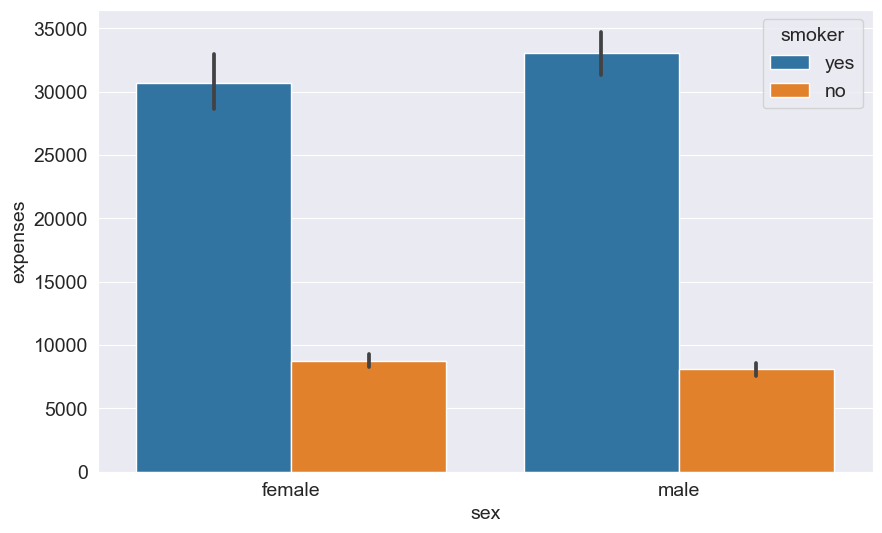

In [44]:
sns.barplot(data = medical_df,x = 'sex',y = 'expenses',hue = "smoker")

In [46]:
px.histogram(medical_df,x='sex',y = 'expenses',color = 'region')

We can infer that from every region our customer base which has males are incurring more bills but interestingly females of northwest region are having more medical bills why is this happening that needs more in dept research

#### Correlation

As you can tell from the analysis, the values in some columns are more closely related to the values in "charges" compared to other columns. E.g. "age" and "charges" seem to grow together, whereas "bmi" and "charges" don't.

This relationship is often expressed numerically using a measure called the correlation coefficient, which can be computed using the .corr method of a Pandas series.

In [48]:
medical_df.expenses.corr(medical_df.age)

0.2990081922850828

In [49]:
medical_df.expenses.corr(medical_df.bmi)

0.198576255018932

In [51]:
medical_df.children.corr(medical_df.expenses)

0.06799823000532818

To compute the correlation for categorical columns, they must first be converted into numeric columns.

In [53]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = medical_df.smoker.map(smoker_values)
medical_df.expenses.corr(smoker_numeric)

0.7872514298985531

Here's how correlation coefficients can be interpreted

Strength: The greater the absolute value of the correlation coefficient, the stronger the relationship.

The extreme values of -1 and 1 indicate a perfectly linear relationship where a change in one variable is accompanied by a perfectly consistent change in the other. For these relationships, all of the data points fall on a line. In practice, you won’t see either type of perfect relationship.

A coefficient of zero represents no linear relationship. As one variable increases, there is no tendency in the other variable to either increase or decrease.

When the value is in-between 0 and +1/-1, there is a relationship, but the points don’t all fall on a line. As r approaches -1 or 1, the strength of the relationship increases and the data points tend to fall closer to a line.

Direction: The sign of the correlation coefficient represents the direction of the relationship.

Positive coefficients indicate that when the value of one variable increases, the value of the other variable also tends to increase. Positive relationships produce an upward slope on a scatterplot.

Negative coefficients represent cases when the value of one variable increases, the value of the other variable tends to decrease. Negative relationships produce a downward slope.

Pandas dataframes also provide a .corr method to compute the correlation coefficients between all pairs of numeric columns.



In [54]:
medical_df.corr()

age       bmi  children  expenses
age       1.000000  0.109341  0.042469  0.299008
bmi       0.109341  1.000000  0.012645  0.198576
children  0.042469  0.012645  1.000000  0.067998
expenses  0.299008  0.198576  0.067998  1.000000

The result of .corr is called a correlation matrix and is often visualized using a heatmap.

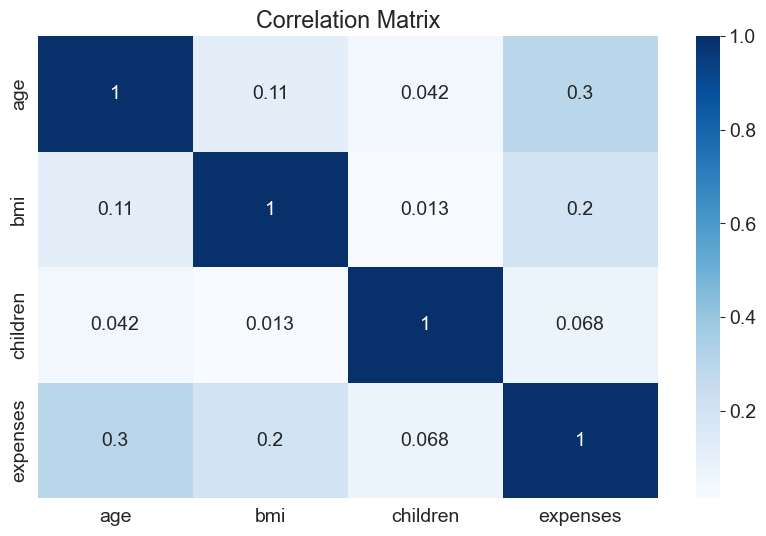

In [55]:
sns.heatmap(medical_df.corr(), cmap='Blues', annot=True)
plt.title('Correlation Matrix');

### Linear Regression using a Single Feature

We now know that the "smoker" and "age" columns have the strongest correlation with "charges". Let's try to find a way of estimating the value of "charges" using the value of "age" for non-smokers. First, let's create a data frame containing just the data for non-smokers.

In [56]:
non_smoker_df = medical_df[medical_df.smoker == 'no']

Next, let's visualize the relationship between "age" and "charges"

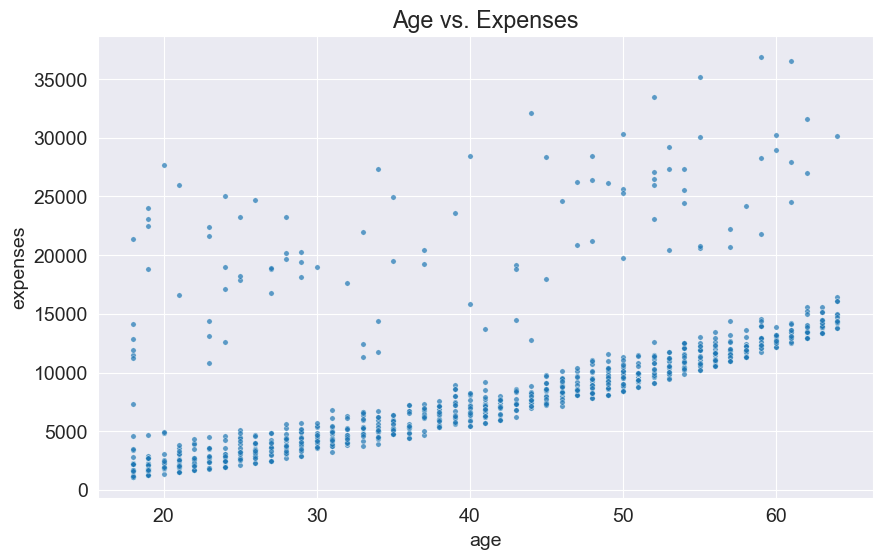

In [57]:
plt.title('Age vs. Expenses')
sns.scatterplot(data=non_smoker_df, x='age', y='expenses', alpha=0.7, s=15);

Apart from a few exceptions, the points seem to form a line. We'll try and "fit" a line using this points, and use the line to predict charges for a given age. A line on the X&Y coordinates has the following formula

y = wx + b

The line is characterized two numbers: w(called "slope") and  b(called "intercept").

#### Model

In the above case, the x axis shows "age" and the y axis shows "charges". Thus, we're assume the following relationship between the two:

charges = w * age + b

We'll try determine w and b for the line that best fits the data.

This technique is called linear regression, and we call the above equation a linear regression model, because it models the relationship between "age" and "charges" as a straight line.

The numbers w and b are called the parameters or weights of the model.

The values in the "age" column of the dataset are called the inputs to the model and the values in the charges column are called "targets".

Let define a helper function estimate_charges, to compute charges, given  
age, w and b.


In [58]:
def estimate_charges(age, w, b):
    return w * age + b

The estimates_charges function is iur very first model.

Let's try some values of w and b

In [59]:
w = 50
b = 100


In [61]:
estimate_charges(30, w, b)

1600

In [64]:
ages = non_smoker_df.age
estimated_charges = estimate_charges(ages, w, b)
estimated_charges

1       1000
2       1500
3       1750
4       1700
5       1650
        ... 
1332    2700
1333    2600
1334    1000
1335    1000
1336    1150
Name: age, Length: 1064, dtype: int64

In [66]:
non_smoker_df.expenses

1        1725.55
2        4449.46
3       21984.47
4        3866.86
5        3756.62
          ...   
1332    11411.69
1333    10600.55
1334     2205.98
1335     1629.83
1336     2007.95
Name: expenses, Length: 1064, dtype: float64

We can plot the estimates charges using  line graph.

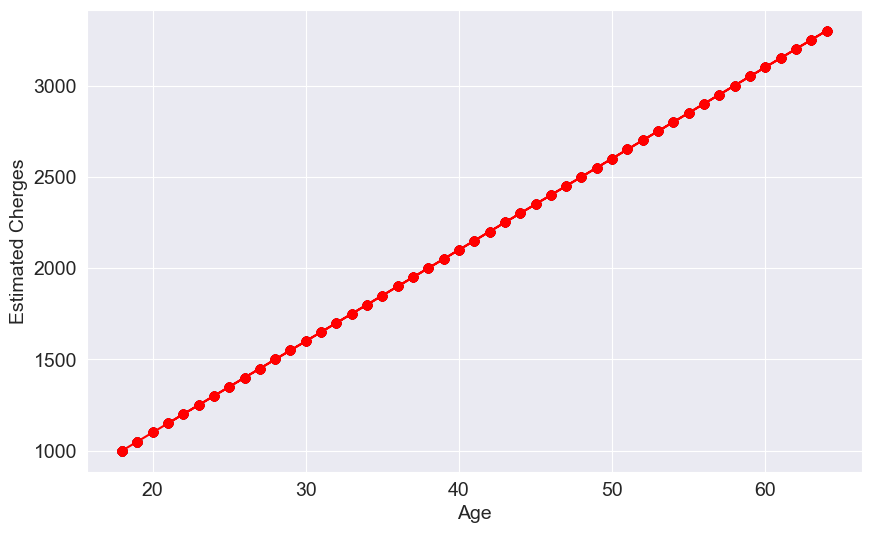

In [67]:
plt.scatter(ages, estimated_charges);
plt.plot(ages, estimated_charges, 'r-o')
plt.xlabel('Age');
plt.ylabel('Estimated Cherges');

As expected, the points lie on a straight line.

We can overlay this line on the actual data, so see how well our model fits the data.

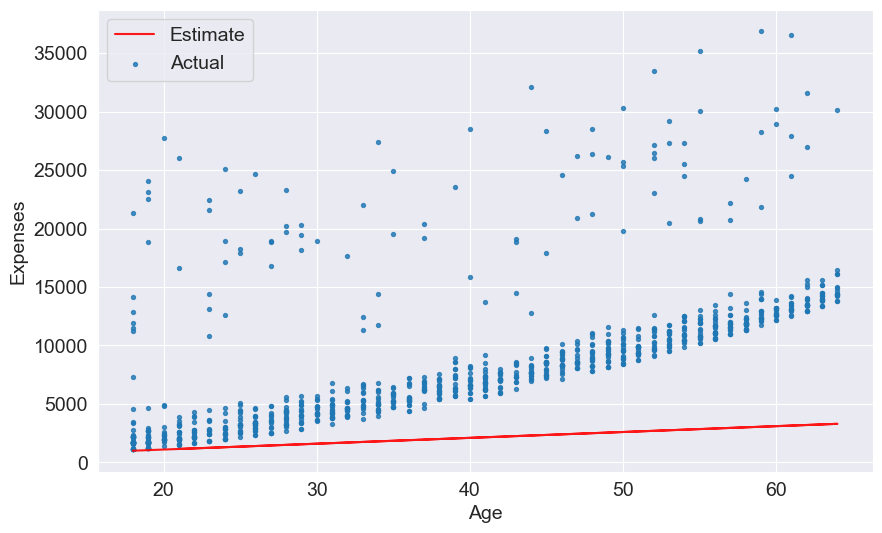

In [70]:
target = non_smoker_df.expenses

plt.plot(ages, estimated_charges, 'r', alpha=0.9);
plt.scatter(ages, target, s=8,alpha=0.8);
plt.xlabel('Age');
plt.ylabel('Expenses')
plt.legend(['Estimate', 'Actual']);

Clearly, the our estimates are quite poor and the line does not "fit" the data. However, we can try different values of  
w
  and  
b
  to move the line around. Let's define a helper function try_parameters which takes w and b as inputs and creates the above plot.

In [79]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.expenses
    
    estimated_charges = estimate_charges(ages, w, b)
    
    plt.plot(ages, estimated_charges, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Expenses')
    plt.legend(['Estimate', 'Actual']);

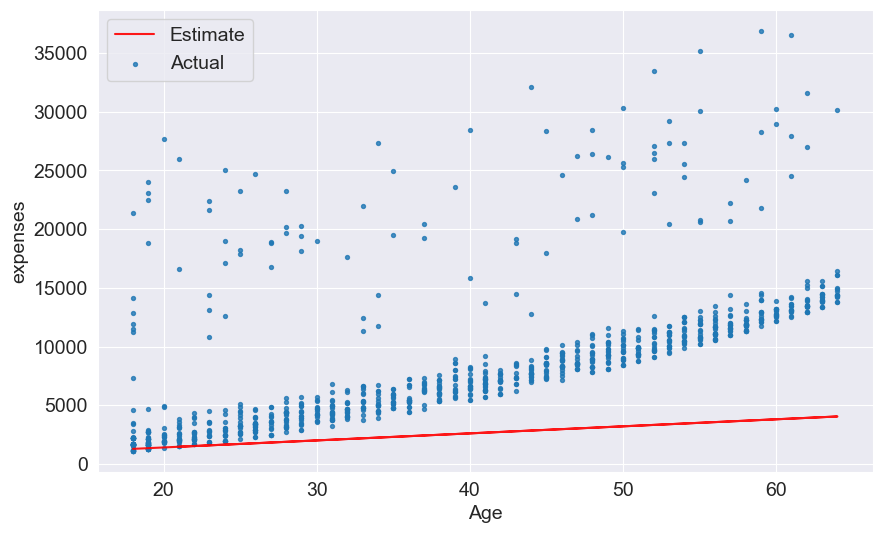

In [81]:
try_parameters(60, 200)


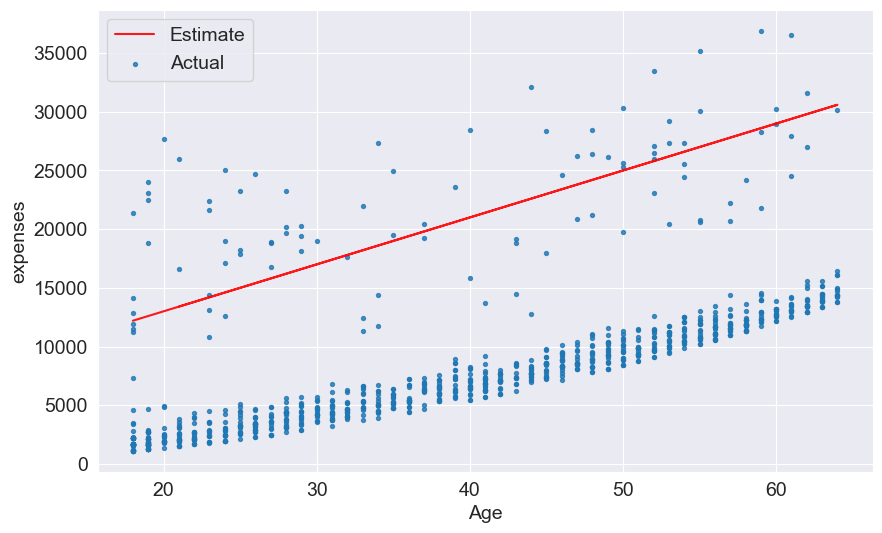

In [82]:
try_parameters(400, 5000)

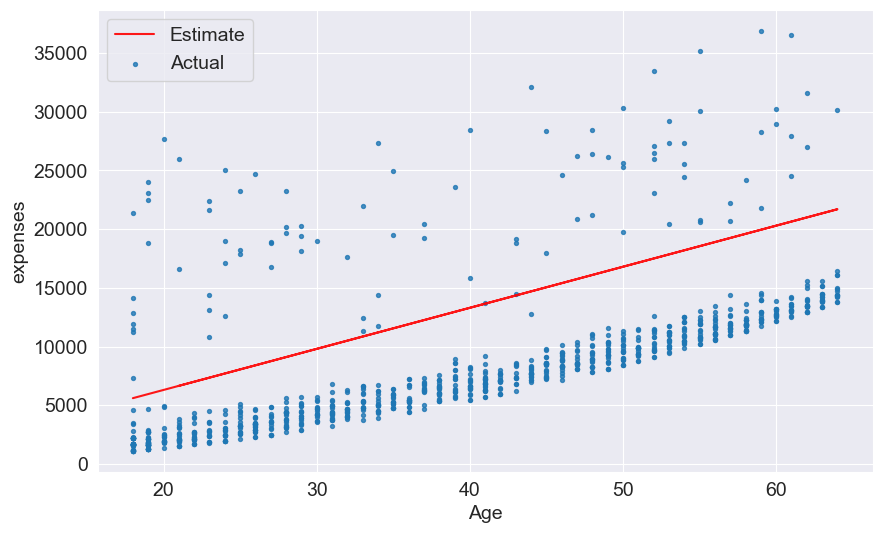

In [83]:
try_parameters(350, -700)

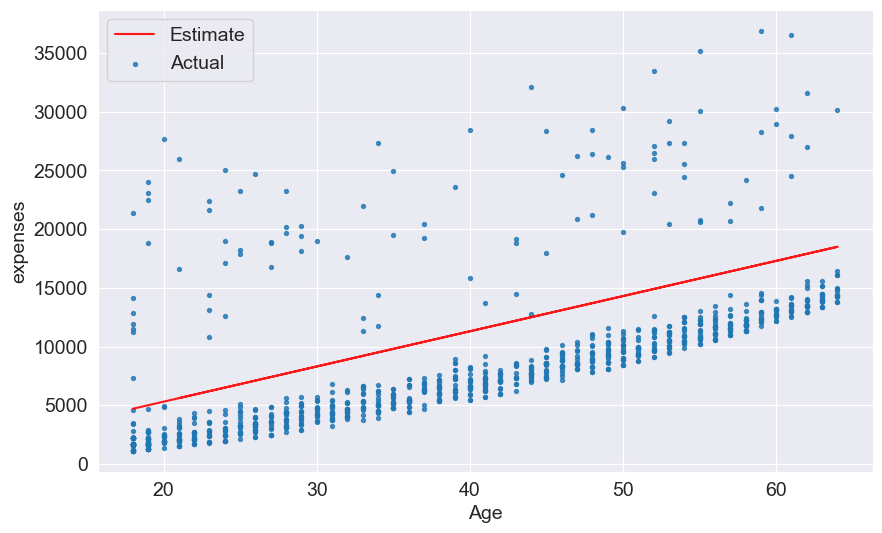

In [84]:
try_parameters(300, -700)

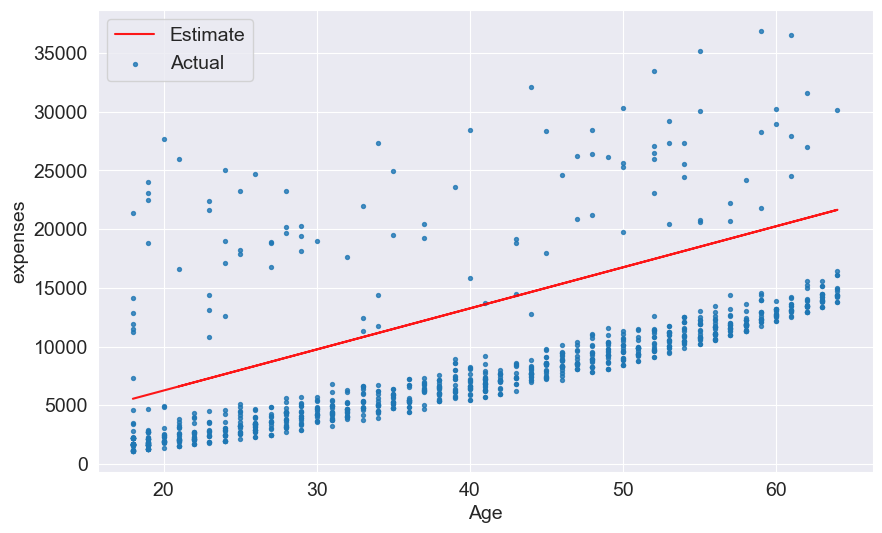

In [85]:
try_parameters(350, -750)

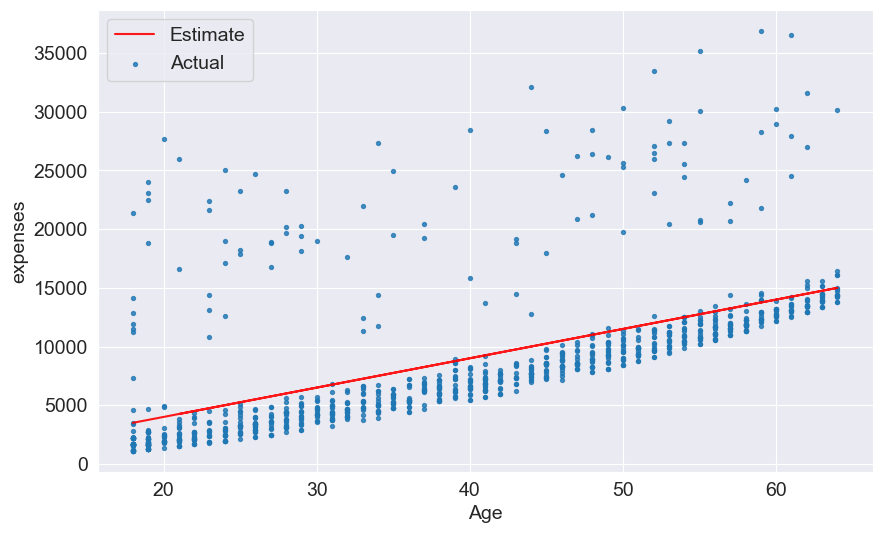

In [86]:
try_parameters(250, -1000)

So,as we decreased the value of b line started coming down and value of w needed to be calibrated as slope was demonstrating wrongful predictions, if we increase the value of w slope of the line increases and vice versa.

As we change the values, of w and b manually, trying to move the line visually closer to the points, we are learning the approximate relationship between "age" and "charges".

Now we need to make our computer do the above task by itself and To do this, we need to solve a couple of problems:

We need a way to measure numerically how well the line fits the points.

Once the "measure of fit" has been computed, we need a way to modify w and b to improve the the fit.

Loss/Cost Function:

We can compare our model's predictions with the actual targets using the following method:

For a Loss function we can use root-mean-squared-method which first calculate the difference between tagets and predictions made by model after that,square of the obtained value is carried out to eliminate the possibility of negative numbers.next comes the mean of the elements and finally to balance out the squaring we square root the results obtained in previous step and thus by this we get our Loss function eligent and very useful.

Let's define a function to compute the RMSE.

In [97]:
!pip install scikit-learn --quiet

In [98]:
import numpy as np

In [109]:
def rmse(targets, predictions):
    return np.sqrt(np.mean(np.mean(np.square(targets - predictions))))

Note:- that the input X must be a 2-d array, so we'll need to pass a dataframe, instead of a single column.

In [110]:
w = 50
b = 100

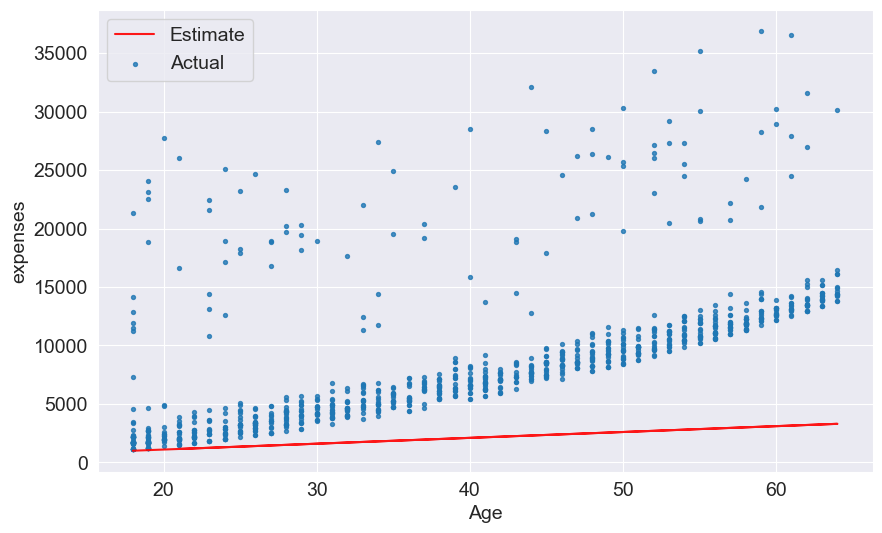

In [111]:
try_parameters(w, b)

In [112]:
targets = non_smoker_df['expenses']
predicted = estimate_charges(non_smoker_df.age, w, b)

In [113]:
rmse(targets, predicted)

8461.94962740416

The result is called the loss because it indicates how bad the model is at predicting the target variables. It represents information loss in the model: the lower the loss, the better the model.

Let's modify the try_parameters functions to also display the loss.

In [115]:
def try_parameters(w, b):
    ages = non_smoker_df.age
    target = non_smoker_df.expenses
    predictions = estimate_charges(ages, w, b)
    
    plt.plot(ages, predictions, 'r', alpha=0.9);
    plt.scatter(ages, target, s=8,alpha=0.8);
    plt.xlabel('Age');
    plt.ylabel('Expenses')
    plt.legend(['Prediction', 'Actual']);
    
    loss = rmse(target, predictions)
    print("RMSE Loss: ", loss)

RMSE Loss:  8461.94962740416


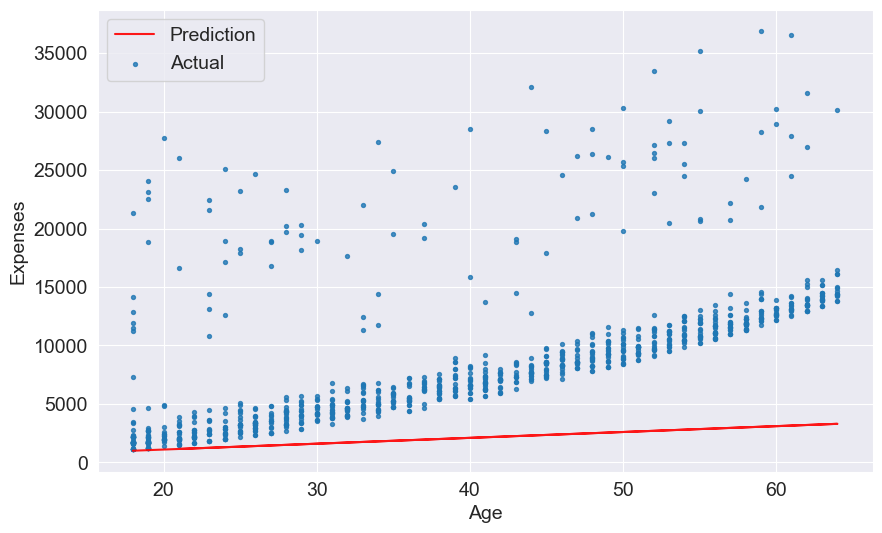

In [116]:
try_parameters(50, 100)

RMSE Loss:  4686.972771604598


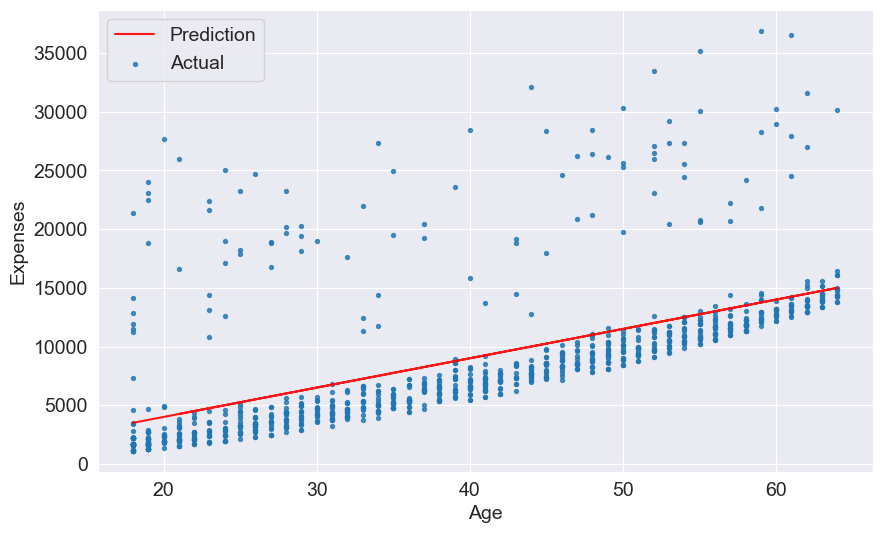

In [117]:
try_parameters(250, -1000)

RMSE Loss:  4673.637481328186


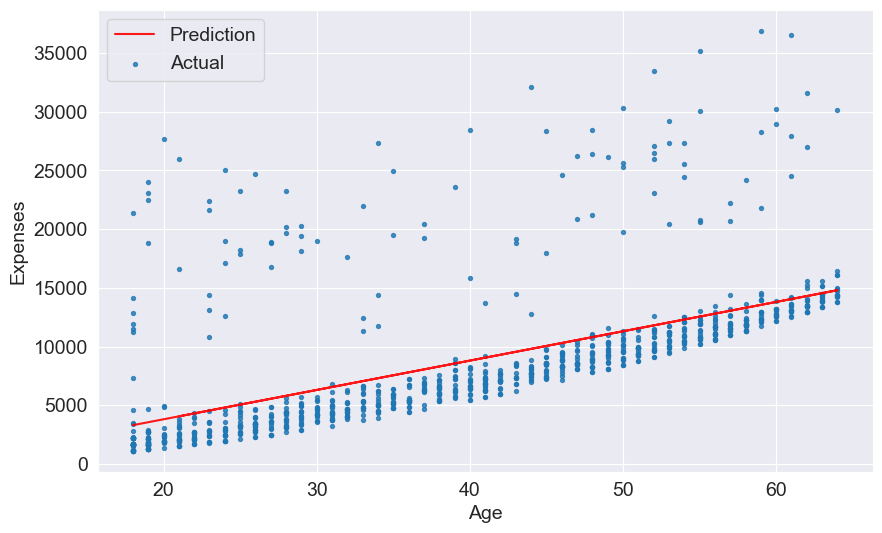

In [118]:
try_parameters(250, -1200)

RMSE Loss:  4664.425914719385


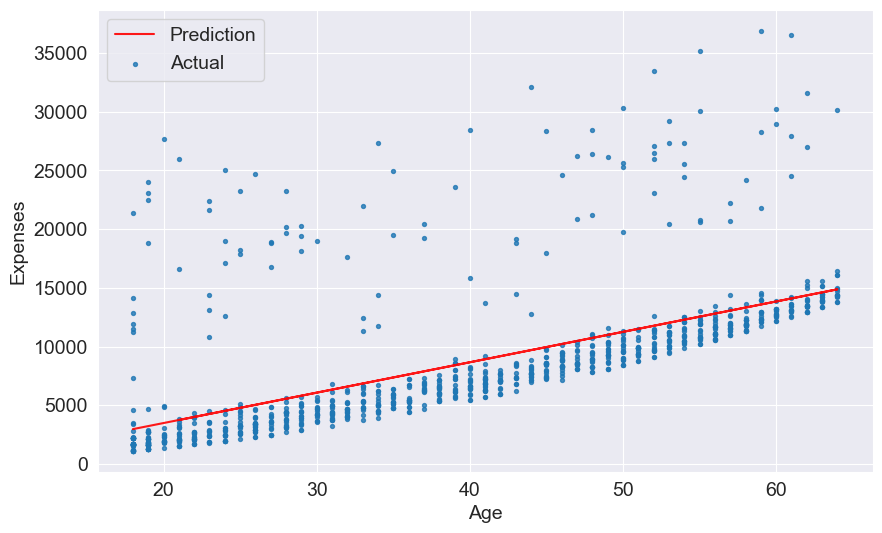

In [119]:
try_parameters(259, -1700)

for the value w = 259 and b = -1700 i got the RMSE value of 4664$ which was the lowest i could get after trying many values.for trial and error you should try by increasing values of parameter by high differences and if try some smaller difference values and incline to choose value of both upper and lower limit which present lower rmse.it's like binary sort algorithm and if you combine this strategy with gradient decent strategy you get a accurate parameters with faster execution.

### Linear Regression using Scikit-learn

In [120]:
!pip install scikit-learn --quiet

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

In [123]:
model = LinearRegression()

In [125]:
inputs = non_smoker_df[['age']]
targets = non_smoker_df.expenses
print('inputs.shape :', inputs.shape)
print('targets.shape :', targets.shape)

inputs.shape : (1064, 1)
targets.shape : (1064,)


Let's fit the model to the data.

In [126]:
model.fit(inputs, targets)

LinearRegression()

In [127]:
predictions = model.predict(inputs)

In [128]:
predictions

array([2719.05994381, 5391.54911046, 6727.79369378, ..., 2719.05994381,
       2719.05994381, 3520.8066938 ])

Let's compute the RMSE loss to evaluate the model.

In [129]:
rmse(targets, predictions)

4662.505642227753

Seems like our prediction is off by $4000 on average, which is not too bad.

The parameters of the model are stored in the coef and intercept properties.

In [130]:
# w
model.coef_

array([267.24891666])

In [131]:
# b
model.intercept_

-2091.42055615141

Optionally:

Use the SGDRegressor class from scikit-learn to train a model using the stochastic gradient descent technique

In [132]:
model1 = SGDRegressor()

In [133]:
model1.fit(inputs, targets)

SGDRegressor()

In [134]:
predictions = model1.predict(inputs)
rmse(targets, predictions)

4967.398544652841

## Model creation for smokers in the dataset

In [135]:
smoker_df = medical_df[medical_df.smoker == 'yes']
smoker_df

age     sex   bmi  children smoker     region  expenses
0      19  female  27.9         0    yes  southwest  16884.92
11     62  female  26.3         0    yes  southeast  27808.73
14     27    male  42.1         0    yes  southeast  39611.76
19     30    male  35.3         0    yes  southwest  36837.47
23     34  female  31.9         1    yes  northeast  37701.88
...   ...     ...   ...       ...    ...        ...       ...
1313   19  female  34.7         2    yes  southwest  36397.58
1314   30  female  23.7         3    yes  northwest  18765.88
1321   62    male  26.7         0    yes  northeast  28101.33
1323   42  female  40.4         2    yes  southeast  43896.38
1337   61  female  29.1         0    yes  northwest  29141.36

[274 rows x 7 columns]

In [136]:
inputs = smoker_df[['age']]
targets = smoker_df.expenses
print('', inputs.shape)
print('',targets.shape)

 (274, 1)
 (274,)


In [137]:
model.fit(inputs, targets)

LinearRegression()

In [138]:
predicted = model.predict(inputs)
print('RMSE:',)
rmse(targets, predicted)

RMSE:


10711.00362995003

### Machine Learning
Every machine learning problem has 3 componets:
1. Model
2. Cost Function
3. Optimizer

In [140]:
# Create inputs and targets
inputs, targets = non_smoker_df[['age']], non_smoker_df['expenses']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4662.505642227753


### Linear Regression using Multiple Features

So far, we've used on the "age" feature to estimate "charges". Adding another feature like "bmi" is fairly straightforward. We simply assume the following relationship:

charges = w1 * age + w2 * bmi + b 

We need to change just one line of code to include the BMI.

In [142]:
# Create inputs and targets
inputs, targets = non_smoker_df[['age', 'bmi']], non_smoker_df['expenses']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4662.320401268678


In [144]:
non_smoker_df.expenses.corr(non_smoker_df.bmi)

0.08392659618660844

In [147]:
fig = px.scatter(non_smoker_df,  x = 'bmi', y = 'expenses', title = 'BMI vs Expenses')
fig.update_traces(marker_size = 5)
fig.show()

We can also visualize the relationship between all 3 variables "age", "bmi" and "charges" using a 3D scatter plot. 

In [149]:
fig = px.scatter_3d(non_smoker_df, x='age', y='bmi', z='expenses')
fig.update_traces(marker_size=3, marker_opacity=0.5)
fig.show()

You can see that it's harder to interpret a 3D scatter plot compared to a 2D scatter plot. As we add more features, it becomes impossible to visualize all feature at once, which is why we use measures like correlation and loss.

This is an important thing to keep in mind: you can't find a relationship that doesn't exist, no matter what machine learning technique or optimization algorithm you apply.

Training a linear regression model to estimate charges using BMI alone

In [151]:
inputs,targets = non_smoker_df[['bmi']],non_smoker_df['expenses']

In [152]:
model = LinearRegression().fit(inputs, targets)

In [153]:
predictions=model.predict(inputs)
loss = rmse(targets,predictions)
print('Loss:',loss)

Loss: 5969.827982982936


As BMI has very less correlation with charges we get a higher loss on a model which predicts charges on the basis of BMI as a independent variable as seen above loss value is increased which is a degradtion in our model

Let's go one step further, and add the final numeric column: "children", which seems to have some correlation with "charges".

expenses  = w1 x age + w2 x bmi + w3 x children + b

In [155]:
non_smoker_df.expenses.corr(non_smoker_df.children)

0.1389287087657859

In [156]:
fig = px.strip(non_smoker_df, x='children', y='expenses', title= "Children vs. Expenses")
fig.update_traces(marker_size=4, marker_opacity=0.7)
fig.show()

In [158]:
# Create inputs and targets
inputs, targets = non_smoker_df[['age', 'bmi', 'children']], non_smoker_df['expenses']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)


Loss: 4608.4754417549975


In [160]:
inputs,targets = smoker_df[['age','children','bmi']],smoker_df['expenses']

In [161]:
model = LinearRegression().fit(inputs, targets)
prediction = model.predict(inputs)

In [162]:
loss = rmse(targets, prediction)
print('Loss', loss)

Loss 5713.984838595673


Repeating the steps in this section to train a linear regression model to estimate medical charges for all customers.

In [164]:
# Create inputs and targets
inputs, targets = medical_df[['age', 'bmi', 'children']], medical_df['expenses']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 11354.838023293312


In [165]:
px.scatter(medical_df,x="age",y="expenses",color='smoker')

Loss is very high compared to earlier. This is because it is easier to fit a line for model when it is grouped for non-smokers and there would be some outliers as shown in above viz.

## Using Categorical Features for Machine Learning

So far we've been using only numeric columns, since we can only perform computations with numbers. If we could use categorical columns like "smoker", we can train a single model for the entire dataset.

To use the categorical columns, we simply need to convert them to numbers. There are three common techniques for doing this:

If a categorical column has just two categories (it's called a binary category), then we can replace their values with 0 and 1.
If a categorical column has more than 2 categories, we can perform one-hot encoding i.e. create a new column for each category with 1s and 0s.
If the categories have a natural order (e.g. cold, neutral, warm, hot), then they can be converted to numbers (e.g. 1, 2, 3, 4) preserving the order. These are called ordinals

### Binary Categories

The "smoker" category has just two values "yes" and "no". Let's create a new column "smoker_code" containing 0 for "no" and 1 for "yes".

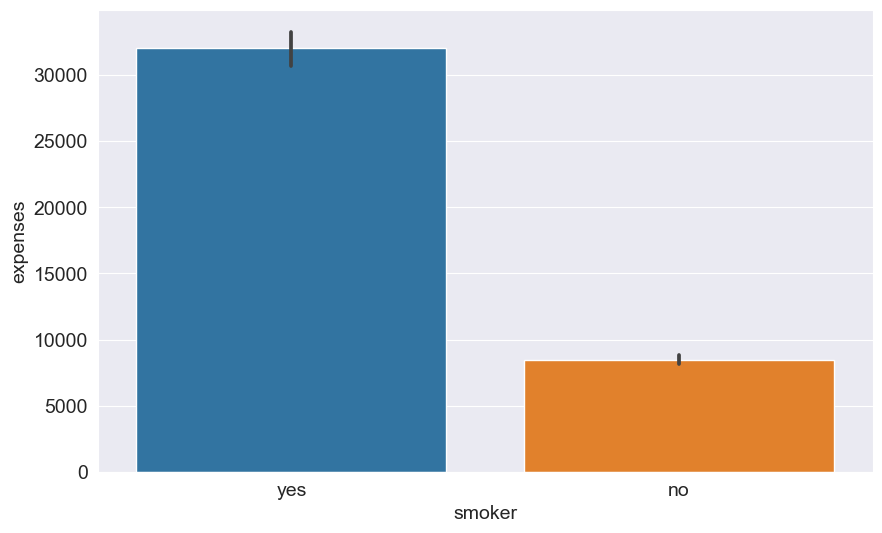

In [167]:
sns.barplot(data = medical_df, x = 'smoker', y = 'expenses');

In [168]:
smoker_codes = {'no': 0, 'yes': 1}
medical_df['smoker_code'] = medical_df.smoker.map(smoker_codes)

In [170]:
medical_df.expenses.corr(medical_df.smoker_code)

0.7872514298985531

medical_df

We can now use the smoker_df column for linear regression.

expenses  = w1 x age + w2 x bmi + w3 x children + w4 x smoker + b

In [173]:
# Create inputs and targets
inputs, targets = medical_df[['age', 'bmi', 'children', 'smoker_code']], medical_df['expenses']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6056.25392250329


The loss reduces from 11355 to 6056, almost by 50%! This is an important lesson: never ignore categorical data.

adding the "sex" column to the mix.

charges = w1 x age + w2 x bmi + w3 x children + w4 x smoker + w5 x sex + b

<AxesSubplot:xlabel='sex', ylabel='expenses'>

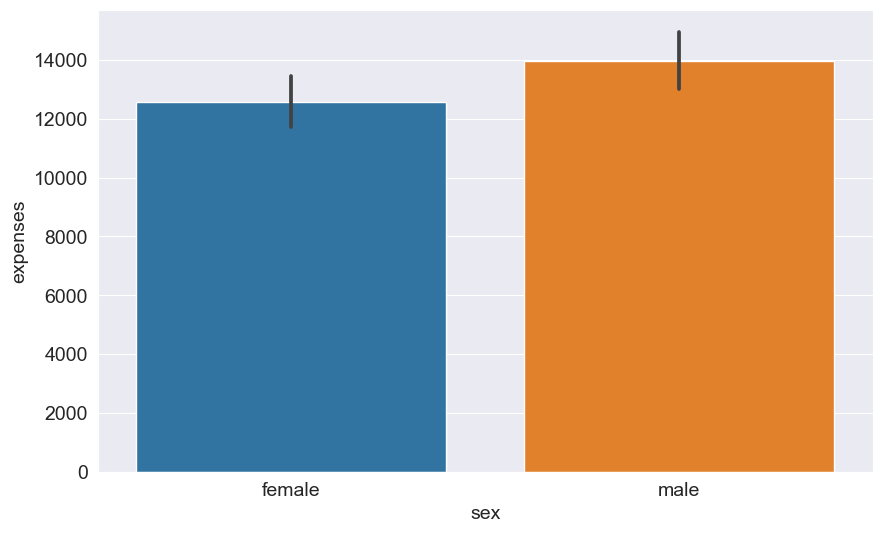

In [174]:
sns.barplot(data=medical_df, x='sex', y='expenses')

In [175]:
sex_codes = {'female':0, 'male': 1}

In [176]:
medical_df['sex_code'] = medical_df.sex.map(sex_codes)

In [177]:
medical_df

age     sex   bmi  children smoker     region  expenses  smoker_code  \
0      19  female  27.9         0    yes  southwest  16884.92            1   
1      18    male  33.8         1     no  southeast   1725.55            0   
2      28    male  33.0         3     no  southeast   4449.46            0   
3      33    male  22.7         0     no  northwest  21984.47            0   
4      32    male  28.9         0     no  northwest   3866.86            0   
...   ...     ...   ...       ...    ...        ...       ...          ...   
1333   50    male  31.0         3     no  northwest  10600.55            0   
1334   18  female  31.9         0     no  northeast   2205.98            0   
1335   18  female  36.9         0     no  southeast   1629.83            0   
1336   21  female  25.8         0     no  southwest   2007.95            0   
1337   61  female  29.1         0    yes  northwest  29141.36            1   

      sex_code  
0            0  
1            1  
2            1  
3            1  
4            1  
...        ...  
1333         1  
1334         0  
1335         0  
1336         0  
1337         0  

[1338 rows x 9 columns]

In [178]:
medical_df.expenses.corr(medical_df.sex_code)

0.05729206999169412

In [179]:
# Create inputs and targets
inputs, targets = medical_df[['age', 'bmi', 'children', 'smoker_code', 'sex_code']], medical_df['expenses']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6055.915185548816


### One-hot Encoding
The "region" column contains 4 values, so we'll need to use hot encoding and create a new column for each region.

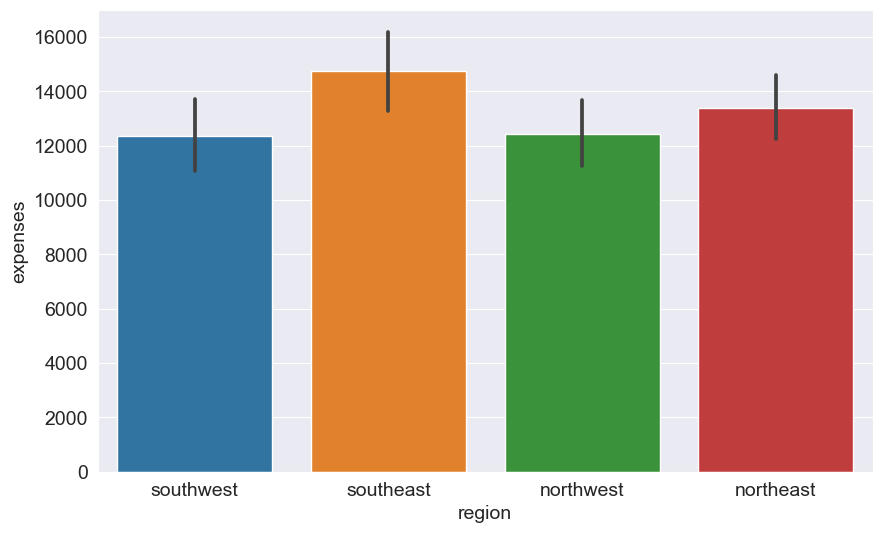

In [180]:
sns.barplot(data=medical_df, x='region', y='expenses');

In [181]:
from sklearn import preprocessing 
enc = preprocessing.OneHotEncoder()
enc.fit(medical_df[['region']])
enc.categories_

[array(['northeast', 'northwest', 'southeast', 'southwest'], dtype=object)]

In [183]:
enc.transform([['northeast']]).toarray()

C:\Users\HARISHA\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names



array([[1., 0., 0., 0.]])

In [184]:
one_hot = enc.transform(medical_df[['region']]).toarray()
one_hot

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [185]:
medical_df[['northeast', 'northwest', 'southeast', 'southwest']] = one_hot

In [186]:
medical_df

age     sex   bmi  children smoker     region  expenses  smoker_code  \
0      19  female  27.9         0    yes  southwest  16884.92            1   
1      18    male  33.8         1     no  southeast   1725.55            0   
2      28    male  33.0         3     no  southeast   4449.46            0   
3      33    male  22.7         0     no  northwest  21984.47            0   
4      32    male  28.9         0     no  northwest   3866.86            0   
...   ...     ...   ...       ...    ...        ...       ...          ...   
1333   50    male  31.0         3     no  northwest  10600.55            0   
1334   18  female  31.9         0     no  northeast   2205.98            0   
1335   18  female  36.9         0     no  southeast   1629.83            0   
1336   21  female  25.8         0     no  southwest   2007.95            0   
1337   61  female  29.1         0    yes  northwest  29141.36            1   

      sex_code  northeast  northwest  southeast  southwest  
0            0        0.0        0.0        0.0        1.0  
1            1        0.0        0.0        1.0        0.0  
2            1        0.0        0.0        1.0        0.0  
3            1        0.0        1.0        0.0        0.0  
4            1        0.0        1.0        0.0        0.0  
...        ...        ...        ...        ...        ...  
1333         1        0.0        1.0        0.0        0.0  
1334         0        1.0        0.0        0.0        0.0  
1335         0        0.0        0.0        1.0        0.0  
1336         0        0.0        0.0        0.0        1.0  
1337         0        0.0        1.0        0.0        0.0  

[1338 rows x 13 columns]

Let's include the region columns into our linear regression model.

$charges = w_1 \times age + w_2 \times bmi + w_3 \times children + w_4 \times smoker + w_5 \times sex + w_6 \times northeast + w_7 \times northwest + w_8 \times southeast

w_9 \times southwest + b$

In [188]:
# Create inputs and targets
input_cols = ['age', 'bmi', 'children', 'smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
inputs, targets = medical_df[input_cols], medical_df['expenses']

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6041.492500628136


Once again, this leads to a fairly small reduction in the loss.

Insightful question: Are two separate linear regression models, one for smokers and one of non-smokers, better than a single linear regression model?

In [190]:
#encoding for sex column in smoker_df
sex_codes = {'female': 0, 'male': 1}
smoker_df['sex_code'] = smoker_df.sex.map(sex_codes) 

#one-hot coding for smoker_df
enc.fit(smoker_df[['region']])
one_hot = enc.transform(smoker_df[['region']]).toarray()
one_hot
smoker_df[['northeast', 'northwest', 'southeast', 'southwest']] = one_hot

# Create inputs and targets
input_cols = ['age', 'bmi', 'children', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
inputs, targets = smoker_df[input_cols], smoker_df['expenses']

# Create and train the model
model_smoker = LinearRegression().fit(inputs, targets)

# Generate predictions
prediction = model_smoker.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, prediction)
print('Loss:', loss)


Loss: 5664.138882086879


C:\Users\HARISHA\AppData\Local\Temp\ipykernel_2456\3564704391.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\HARISHA\AppData\Local\Temp\ipykernel_2456\3564704391.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [191]:
#encoding for sex column in smoker_df
sex_codes = {'female': 0, 'male': 1}
non_smoker_df['sex_code'] = non_smoker_df.sex.map(sex_codes) 

#one-hot coding for smoker_df
enc.fit(non_smoker_df[['region']])
one_hot = enc.transform(non_smoker_df[['region']]).toarray()
one_hot
non_smoker_df[['northeast', 'northwest', 'southeast', 'southwest']] = one_hot

# Create inputs and targets
input_cols = ['age', 'bmi', 'children', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
inputs, targets = non_smoker_df[input_cols], non_smoker_df['expenses']

# Create and train the model
model_non_smoker= LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model_non_smoker.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 4573.094226488061


C:\Users\HARISHA\AppData\Local\Temp\ipykernel_2456\2919261896.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\HARISHA\AppData\Local\Temp\ipykernel_2456\2919261896.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\HARISHA\AppData\Local\Temp\ipykernel_2456\2919261896.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

From above results it is evident that we should be using different model for smoker and non-smoker customers as loss from combined dataframe was around 6000 but,on the other hand we got loss of around 5000 for smokers and 4500 for non-smokers which is better than using only one model for whole customer base.

### Model Improvements

Feature Scaling:

Recall that due to regulatory requirements, we also need to explain the rationale behind the predictions our model.

expenses =  w1 x age + w2 x bmi + w3 x children + w4 X smoker + w5 x sex + w6 x region + b

To compare the importance of each feature in the model, our first instinct might be to compare their weights.

In [192]:
model.coef_

array([  256.83917062,   339.28986331,   475.68891551, 23847.47669504,
        -131.35201411,   586.92290648,   234.13281096,  -448.67279452,
        -372.38292292])

In [193]:
model.intercept_

-12528.485367335852

In [194]:
input_cols = ['age', 'bmi', 'children', 'smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']

weights_df = pd.DataFrame({
    'feature': np.append(input_cols, 1),
    'weight': np.append(model.coef_ , model.intercept_)
})
weights_df

feature        weight
0          age    256.839171
1          bmi    339.289863
2     children    475.688916
3  smoker_code  23847.476695
4     sex_code   -131.352014
5    northeast    586.922906
6    northwest    234.132811
7    southeast   -448.672795
8    southwest   -372.382923
9            1 -12528.485367

In [195]:
medical_df


age     sex   bmi  children smoker     region  expenses  smoker_code  \
0      19  female  27.9         0    yes  southwest  16884.92            1   
1      18    male  33.8         1     no  southeast   1725.55            0   
2      28    male  33.0         3     no  southeast   4449.46            0   
3      33    male  22.7         0     no  northwest  21984.47            0   
4      32    male  28.9         0     no  northwest   3866.86            0   
...   ...     ...   ...       ...    ...        ...       ...          ...   
1333   50    male  31.0         3     no  northwest  10600.55            0   
1334   18  female  31.9         0     no  northeast   2205.98            0   
1335   18  female  36.9         0     no  southeast   1629.83            0   
1336   21  female  25.8         0     no  southwest   2007.95            0   
1337   61  female  29.1         0    yes  northwest  29141.36            1   

      sex_code  northeast  northwest  southeast  southwest  
0            0        0.0        0.0        0.0        1.0  
1            1        0.0        0.0        1.0        0.0  
2            1        0.0        0.0        1.0        0.0  
3            1        0.0        1.0        0.0        0.0  
4            1        0.0        1.0        0.0        0.0  
...        ...        ...        ...        ...        ...  
1333         1        0.0        1.0        0.0        0.0  
1334         0        1.0        0.0        0.0        0.0  
1335         0        0.0        0.0        1.0        0.0  
1336         0        0.0        0.0        0.0        1.0  
1337         0        0.0        1.0        0.0        0.0  

[1338 rows x 13 columns]

In [196]:
from sklearn.preprocessing import StandardScaler

In [198]:
numeric_cols = ['age', 'bmi', 'children']
scaler = StandardScaler()
scaler.fit(medical_df[numeric_cols])

StandardScaler()

In [199]:
scaler.mean_

array([39.20702541, 30.66547085,  1.09491779])

In [200]:
scaler.var_

array([197.25385199,  37.16246992,   1.45212664])

We can now scale data as follows:

In [203]:
medical_df[numeric_cols]

age   bmi  children
0      19  27.9         0
1      18  33.8         1
2      28  33.0         3
3      33  22.7         0
4      32  28.9         0
...   ...   ...       ...
1333   50  31.0         3
1334   18  31.9         0
1335   18  36.9         0
1336   21  25.8         0
1337   61  29.1         0

[1338 rows x 3 columns]

In [202]:
scaled_inputs = scaler.transform(medical_df[numeric_cols])
scaled_inputs

array([[-1.43876426, -0.4536457 , -0.90861367],
       [-1.50996545,  0.51418574, -0.07876719],
       [-0.79795355,  0.38295436,  1.58092576],
       ...,
       [-1.50996545,  1.02270734, -0.90861367],
       [-1.29636188, -0.79812808, -0.90861367],
       [ 1.55168573, -0.25679863, -0.90861367]])

These can now we combined with the categorical data

In [204]:
cat_cols = ['smoker_code', 'sex_code', 'northeast', 'northwest', 'southeast', 'southwest']
categorical_data = medical_df[cat_cols].values

In [206]:
inputs = np.concatenate((scaled_inputs, categorical_data), axis=1)
targets = medical_df.expenses

# Create and train the model
model = LinearRegression().fit(inputs, targets)

# Generate predictions
predictions = model.predict(inputs)

# Compute loss to evalute the model
loss = rmse(targets, predictions)
print('Loss:', loss)

Loss: 6041.492500628136


We can now compare the weights in the formula:

expenses = w1 x age + w2 x bmi + w3 x children + w4 X smoker + w5 x sex + w6 x region + b 

In [207]:
weights_df = pd.DataFrame({
    'feature': np.append(numeric_cols + cat_cols, 1),
    'weight': np.append(model.coef_, model.intercept_)
})
weights_df.sort_values('weight', ascending=False)

feature        weight
3  smoker_code  23847.476695
9            1   8466.738191
0          age   3607.231421
1          bmi   2068.345902
5    northeast    586.922906
2     children    573.225204
6    northwest    234.132811
4     sex_code   -131.352014
8    southwest   -372.382923
7    southeast   -448.672795

As you can see now, the most important feature are:

1.Smoker
2.Age
3.BMI

In [208]:
new_customers = [[28,30,2,1,0,0,1,0,0.]]
scaler.transform([[28,30,2]])

C:\Users\HARISHA\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but StandardScaler was fitted with feature names



array([[-0.79795355, -0.10916332,  0.75107928]])

In [209]:
model.predict([[-0.79795355, -0.10882659,  0.75107928,1,0,0,1,0,0.]])

array([29875.39112057])

### Creating a Testing

In [210]:
from sklearn.model_selection import train_test_split

In [211]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs, targets, test_size=0.2,random_state=0)

In [212]:
# Create and train the model
model = LinearRegression().fit(inputs_train, targets_train)

# Generate predictions
predictions_test = model.predict(inputs_test)

# Compute loss to evalute the model
loss = rmse(targets_test, predictions_test)
print('Test Loss:', loss)

Test Loss: 5641.193519411497


Let's compare this with the training loss

In [213]:
# Generate predictions
predictions_train = model.predict(inputs_train)

# Compute loss to evalute the model
loss = rmse(targets_train, predictions_train)
print('Training Loss:', loss)

Training Loss: 6140.028812282909


##### Workflow of Machine Learning Problem
1. Explore the data and find correlations between inputs and targets
2. Pick the right model, loss functions and optimizer for the problem at hand
3. Scale numeric variables and one-hot encode categorical data
4. Set aside a test set (using a fraction of the training set)
5. Train the model
6. Make predictions on the test set and compute the loss